# Real and Fake Faces identification with CNN
## Valentina Moreno, Juliana Henao, Santiago Cano y Gerónimo Zuluaga

Este código instancia y entrena una red neuronal convolucional para la detección de deepfake en imágenes de rostros. Los datos se encuentan en la carpeta "real_and_fake_face" de este proyecto.

## Install and import libraries

In [1]:
pip freeze > requirements.txt

In [2]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 27.9 MB/s 
Processing /colabtools/dist/google-colab-1.0.0.tar.gz
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from pathlib import Path

# Bagging imports
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from multiprocessing import Pool

In [7]:
# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # for showing images
print('matplotlib: %s' % matplotlib.__version__) # print version

# Other utilities
import sys
import os

# Assign main directory to a variable 

# from google.colab import drive
# drive.mount('/content/drive')

main_dir = "/real_and_fake_face"
# main_dir = "data"
# print(main_dir)

Tensorflow/Keras: 2.9.0
pandas: 1.3.5
numpy: 1.21.6
sklearn: 1.0.2
OpenCV: 4.6.0
matplotlib: 3.2.2
Mounted at /content/drive


## Read images

In [8]:
# Specify the location of images after you have downloaded them
ImgLocation=main_dir+"/training_"

# List image categories we are interested in
LABELS = set(["real", "fake"])

# Create two lists to contain image paths and image labels
ImagePaths=[]
ListLabels=[]
for label in LABELS:
    for image in list(os.listdir(ImgLocation+label)):
        ImagePaths=ImagePaths+[ImgLocation+label+"/"+image]
        ListLabels=ListLabels+[label]

In [17]:
# Load images and resize to be a fixed 128x128 pixels, ignoring original aspect ratio
data=[]
for img in ImagePaths:
    image = cv2.imread(img)
    # image = cv2.resize(image, (2, 2))
    image = cv2.resize(image, (64, 64))
    data.append(image)

In [18]:
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data = np.array(data, dtype="float") / 255.0

# Show data shape
print("Shape of whole data: ", data.shape)

# Convert Labels list to numpy array
LabelsArray=np.array(ListLabels)

# Encode labels 
enc = OrdinalEncoder()
y=enc.fit_transform(LabelsArray.reshape(-1,1))

Shape of whole data:  (3993, 64, 64, 3)


In [19]:
# ---- Create training and testing samples ---
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

# Print shapes
# Note, model input must have a four-dimensional shape [samples, rows, columns, channels]
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (3194, 64, 64, 3)
Shape of y_train:  (3194, 1)
Shape of X_test:  (799, 64, 64, 3)
Shape of y_test:  (799, 1)


## Visualization

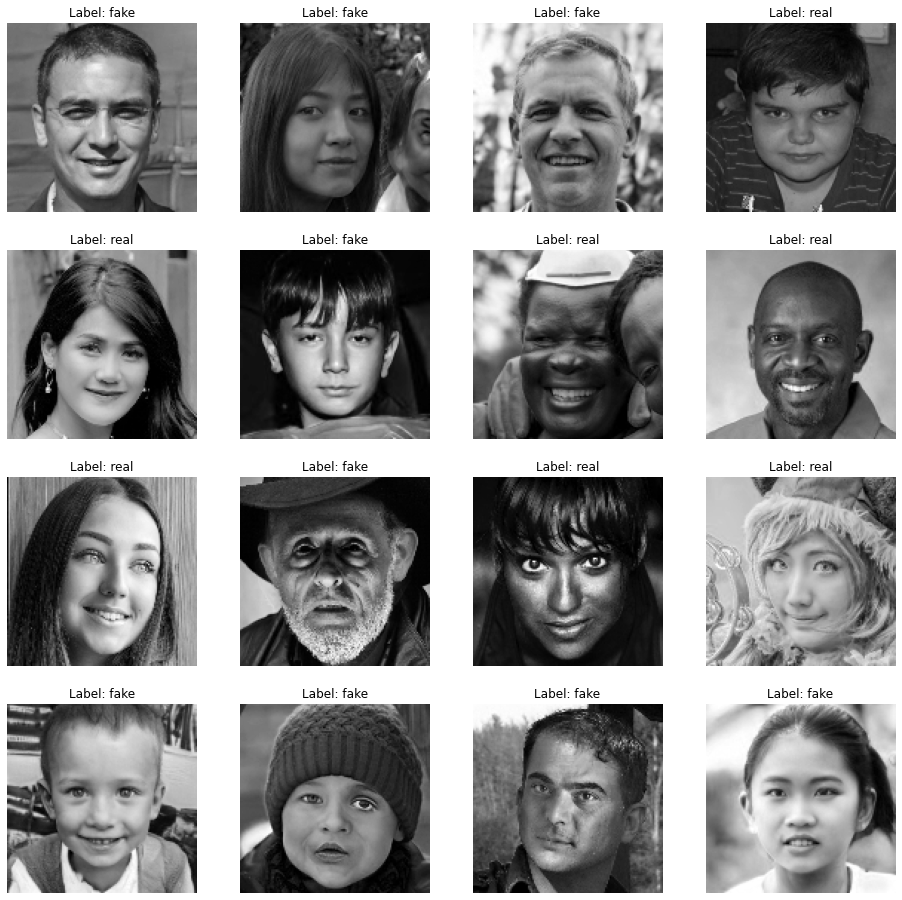

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    if y_train[i] : 
      label='real'
    else:
      label='fake'
    plt.title('Label: '+ label)
    img = np.uint8(255*X_train[i,:,:,0])
    plt.imshow(img, cmap='gray')


Text(0.5, 0, 'Class')

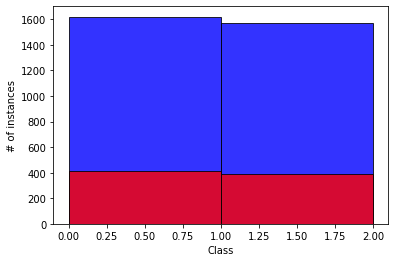

In [ ]:
# Histograma de clases
h1 = plt.hist(y_train, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(y_test,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

# Error measure

In [12]:
def error_i(y_real, y_pred):
  '''
  Computes the error for the given class_ using the true labels (labels) and the model's prediction
  (predictions)
  '''
  classes = list(set(y_real.flatten()))
  err={}
  for i in classes:
    cont = 0
    for j,real in enumerate(y_real):
      if real == i and y_pred[j] != real: cont +=1
    err[str(i)]= cont/len(y_real)
  return err

def compute_error(prediction, labels, class_):
  '''
  Computes the error for the given class_ using the true labels (labels) and the model's prediction
  (predictions)
  '''
  sum = 0
  for i,label in enumerate(labels):
    if label == class_ and prediction[i] != label:
      sum += 1
  return sum/len(labels)

# Red Neuronal Convolucional

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# model1.fit(X_train, y_train, epochs=20)
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12)

Epoch 1/12
100/100 [==============================] - 81s 797ms/step - loss: 0.7074 - accuracy: 0.5178 - val_loss: 0.6849 - val_accuracy: 0.5569
Epoch 2/12
100/100 [==============================] - 73s 729ms/step - loss: 0.6792 - accuracy: 0.5701 - val_loss: 0.6826 - val_accuracy: 0.5645
Epoch 3/12
100/100 [==============================] - 73s 728ms/step - loss: 0.6672 - accuracy: 0.6024 - val_loss: 0.6733 - val_accuracy: 0.5832
Epoch 4/12
100/100 [==============================] - 70s 702ms/step - loss: 0.6496 - accuracy: 0.6331 - val_loss: 0.6610 - val_accuracy: 0.6120
Epoch 5/12
100/100 [==============================] - 70s 702ms/step - loss: 0.6331 - accuracy: 0.6459 - val_loss: 0.6914 - val_accuracy: 0.6108
Epoch 6/12
100/100 [==============================] - 68s 680ms/step - loss: 0.6072 - accuracy: 0.6672 - val_loss: 0.6568 - val_accuracy: 0.6083
Epoch 7/12
100/100 [==============================] - 70s 704ms/step - loss: 0.5782 - accuracy: 0.6979 - val_loss: 0.6638 - val_ac

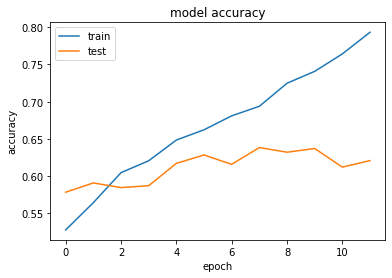

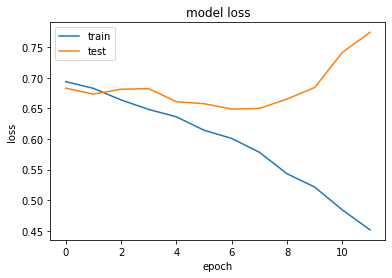

In [ ]:
# Accuracy and loss history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model1.predict(X_test)

25/25 [==============================] - 5s 190ms/step


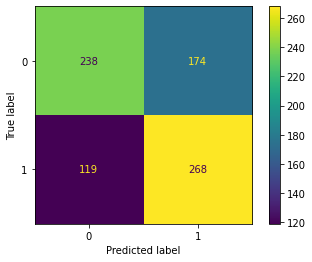

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = [(i>=0.5).astype('int') for i in y_pred]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Bagging tensorflow

In [13]:
def CNN_model_training(X_train, y_train, X_test, y_test):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)
  y_pred = model.predict(X_test)
  err = error_i(y_test, y_pred)
  return model, y_pred, test_acc, err, history

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # sum across ensemble members
  summed = np.mean(yhats, axis=0)
  # argmax across classes
  #result = np.argmax(summed, axis=1)
  result = summed
  print(len(members))
  print(yhats.shape)
  return result

def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  y_pred = ensemble_predictions(subset, testX)
  y_val = [(i>=0.5).astype('int') for i in y_pred]
  y_val = np.array(y_val)
  # calculate accuracy
  return accuracy_score(testy, y_val), y_pred

In [14]:
# multiple train-test splits
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
n_splits = 5 # numero de ensambles
scores, members, predictions, errors, histories = list(), list(), list(), list(), list()

# Entrenamiento
def parallel_training(n_splits):
	# split data
  for i in range(n_splits):
    print(i)
    trainX, testX, trainy, testy = train_test_split(X_train, y_train, test_size=0.15)
    trainy = trainy.reshape(-1,1)
    testy = testy.reshape(-1,1)
    # trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
    # evaluate model
    model, y_pred, test_acc, err, history = CNN_model_training(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)
    predictions.append(y_pred)
    errors.append(err)
    histories.append(history)
  return members, histories

In [21]:
members, histories = parallel_training(n_splits)

0
Epoch 1/15
85/85 [==============================] - 27s 309ms/step - loss: 0.6965 - accuracy: 0.5022 - val_loss: 0.6928 - val_accuracy: 0.4854
Epoch 2/15
85/85 [==============================] - 15s 178ms/step - loss: 0.6885 - accuracy: 0.5402 - val_loss: 0.6776 - val_accuracy: 0.5979
Epoch 3/15
85/85 [==============================] - 14s 163ms/step - loss: 0.6722 - accuracy: 0.5833 - val_loss: 0.6633 - val_accuracy: 0.5979
Epoch 4/15
85/85 [==============================] - 14s 163ms/step - loss: 0.6619 - accuracy: 0.6083 - val_loss: 0.6500 - val_accuracy: 0.6333
Epoch 5/15
85/85 [==============================] - 16s 185ms/step - loss: 0.6476 - accuracy: 0.6275 - val_loss: 0.6550 - val_accuracy: 0.6333
Epoch 6/15
85/85 [==============================] - 14s 166ms/step - loss: 0.6295 - accuracy: 0.6525 - val_loss: 0.6508 - val_accuracy: 0.6458
Epoch 7/15
85/85 [==============================] - 14s 164ms/step - loss: 0.6140 - accuracy: 0.6636 - val_loss: 0.6302 - val_accuracy: 0.65

In [31]:
accs = []
losss = []
for i in histories:
  accs.append(i.history['accuracy'])
  losss.append(i.history['loss'])

ensemble_acc = np.mean(accs)
ensemble_loss = np.mean(losss)

print('ensemble acc: ', ensemble_acc)
print('ensemble loss: ', ensemble_loss)

ensemble acc:  0.6778555645545323
ensemble loss:  0.578989468216896


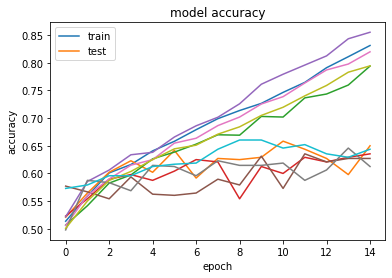

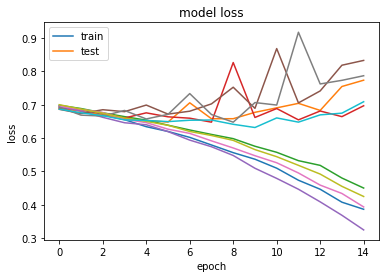

In [ ]:
# Accuracy and loss history
for i in histories:
  plt.plot(i.history['accuracy'])
  plt.plot(i.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
for i in histories:
  plt.plot(i.history['loss'])
  plt.plot(i.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# evaluate different numbers of ensembles on hold out set

single_scores, ensemble_scores, ensemble_errors = list(), list(), list()
for i in range(1, n_splits+1):
  print(i)
  ensemble_score, y_pred = evaluate_n_members(members, i, X_test, y_test)
  # newy_enc = to_categorical(y_test)
  _, single_score = members[i-1].evaluate(X_test, y_test, verbose=2)
  ensemble_err = error_i(y_test, y_pred)
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)
  ensemble_errors.append(ensemble_err)

1
25/25 [==============================] - 1s 42ms/step
1
(1, 799, 1)
25/25 - 1s - loss: 0.8025 - accuracy: 0.6320 - 992ms/epoch - 40ms/step
> 1: single=0.632, ensemble=0.632
2
25/25 [==============================] - 1s 41ms/step
2
(2, 799, 1)
25/25 - 1s - loss: 0.7559 - accuracy: 0.6083 - 1s/epoch - 40ms/step
> 2: single=0.608, ensemble=0.643
3
25/25 [==============================] - 1s 44ms/step
3
(3, 799, 1)
25/25 - 1s - loss: 0.8298 - accuracy: 0.6408 - 984ms/epoch - 39ms/step
> 3: single=0.641, ensemble=0.653
4
25/25 [==============================] - 1s 42ms/step
4
(4, 799, 1)
25/25 - 1s - loss: 0.7691 - accuracy: 0.6370 - 1s/epoch - 40ms/step
> 4: single=0.637, ensemble=0.652
5
25/25 [==============================] - 1s 41ms/step
5
(5, 799, 1)
25/25 - 2s - loss: 0.7231 - accuracy: 0.6458 - 2s/epoch - 66ms/step
> 5: single=0.646, ensemble=0.648


In [ ]:
print(ensemble_scores)
print(ensemble_errors)
print(single_scores)

[0.6320400500625782, 0.6433041301627034, 0.6533166458072591, 0.6520650813516896, 0.6483103879849812]
[{'0.0': 0.5156445556946183, '1.0': 0.48435544430538174}, {'0.0': 0.5156445556946183, '1.0': 0.48435544430538174}, {'0.0': 0.5156445556946183, '1.0': 0.48435544430538174}, {'0.0': 0.5156445556946183, '1.0': 0.48435544430538174}, {'0.0': 0.5156445556946183, '1.0': 0.48435544430538174}]
[0.6320400238037109, 0.6082603335380554, 0.6408010125160217, 0.6370463371276855, 0.6458072662353516]


In [ ]:
y_pred = model1.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = [(i>=0.5).astype('int') for i in y_pred]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()